input_array_test = (18000, 6)
model = Net(
  (lstm): LSTM(6, 10, num_layers=3, batch_first=True)
  (fc): Linear(in_features=10, out_features=3, bias=True)
)
predicted = torch.Size([17993])
Fx 평균 오차 (MAE_X): 0.6525
Fy 평균 오차 (MAE_Y): 0.7798
Fz 평균 오차 (MAE_Z): 5.6779
Fx RMSE: 1.3038
Fy RMSE: 1.8430
Fz RMSE: 11.4178
Fx_delay = -3
Fy_delay = -1
Fz_delay = -2


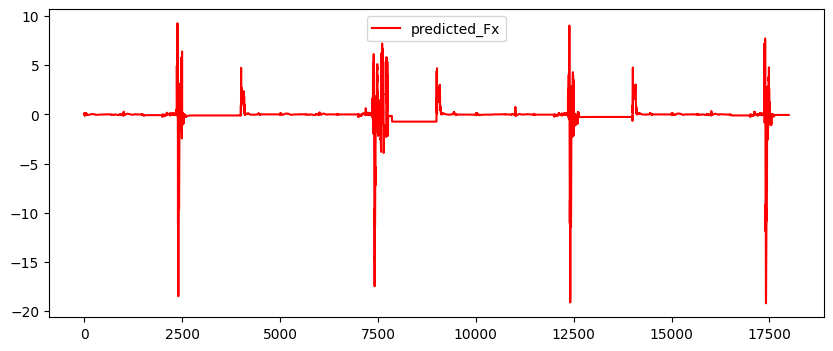

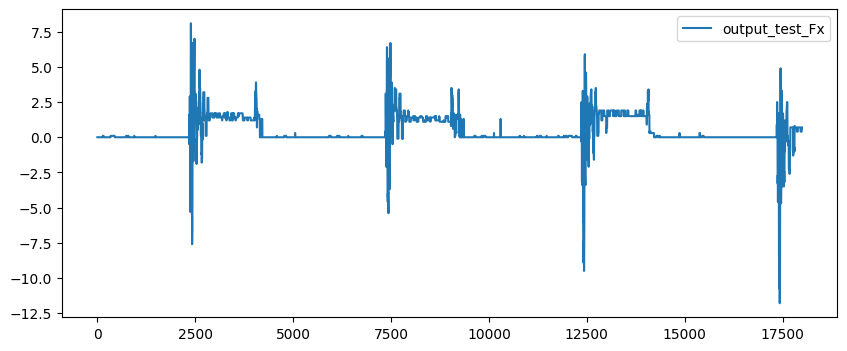

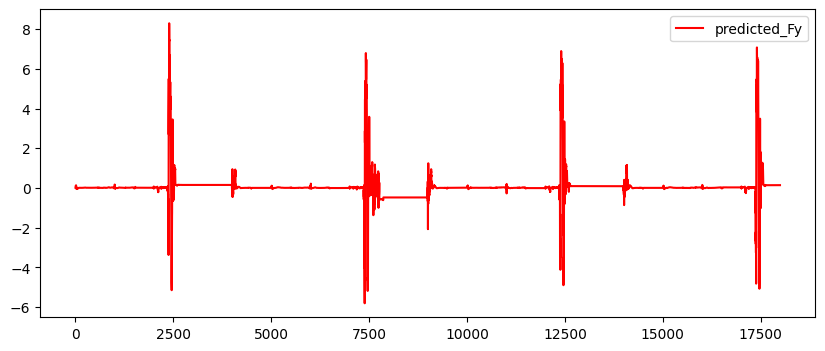

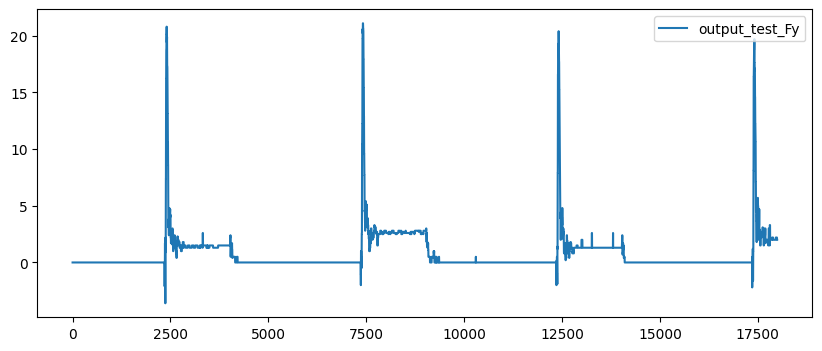

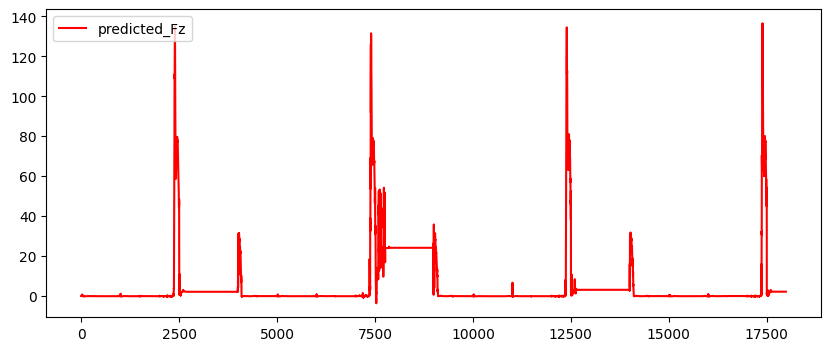

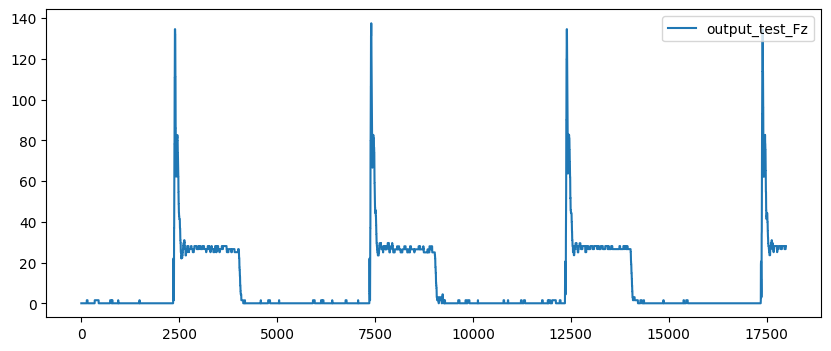

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from datetime import datetime
from scipy.signal import correlate
from torch.autograd import Variable 

device = 'cuda' if torch.cuda.is_available() else 'cpu'
rawdata = pd.read_csv("DatasetCSV/TakeTest7_dataset.csv")

Data_foot_Fx = rawdata["Fx_foot"]
Data_foot_Fy = rawdata["Fy_foot"]
Data_foot_Fz = rawdata["Fz_foot"]

output_array_test_x = np.array(Data_foot_Fx[0:17993:])
output_array_test_x = output_array_test_x.reshape(-1,1)
output_array_test_y = np.array(Data_foot_Fy[0:17993:])
output_array_test_y = output_array_test_y.reshape(-1,1)
output_array_test_z = np.array(Data_foot_Fz[0:17993:])
output_array_test_z = output_array_test_z.reshape(-1,1)

Data_knee_pitch_q_error = rawdata["q_err_KP"]
Data_knee_pitch_q_dot_error = rawdata["qdot_err_KP"]
Data_Z_error = rawdata["z_error"]
Data_hip_roll_Torque = rawdata["Tor_HR"]
Data_hip_pitch_Torque = rawdata["Tor_HP"] 
Data_knee_pitch_Torque = rawdata["Tor_KP"]

len_data = len(Data_knee_pitch_q_error)
input_array = np.empty((0,6))
input_data_list = []

for i in range(len_data):
    input_data_list.append(Data_knee_pitch_q_error[i])
    input_data_list.append(Data_knee_pitch_q_dot_error[i])
    input_data_list.append(Data_Z_error[i])
    input_data_list.append(Data_hip_roll_Torque[i])
    input_data_list.append(Data_hip_pitch_Torque[i])
    input_data_list.append(Data_knee_pitch_Torque[i])
    
    
    if len(input_data_list) == 6:
        input_array = np.append(input_array, np.array([input_data_list]), axis = 0) 
        input_data_list = []

input_array_test = np.array(input_array)
print(f'input_array_test = {input_array_test.shape}')

seq_length = 7

def build_dataset(time_series_data, sequence_length):
    data = []
    for i in range(0, len(time_series_data)-sequence_length):
        _x = time_series_data[i:i+sequence_length, :]
        data.append(_x)        
    return np.array(data)


# output_train_data = output_train_dataset


input_array_test = build_dataset(input_array_test, seq_length)

output_test_x = torch.FloatTensor(output_array_test_x).to(device)
output_test_y = torch.FloatTensor(output_array_test_y).to(device)
output_test_z = torch.FloatTensor(output_array_test_z).to(device)

batch_size = 32
input_test = torch.FloatTensor(input_array_test).to(device)


data_dim = 6
hidden_dim = 10
output_dim = 3
learning_rate = 0.01
epochs = 1000
lstm_layers = 3

class Net(nn.Module):
    def __init__(self, input_dim, hidden_dim, sequence_len, output_dim, layers):
        super(Net, self).__init__()
        self.hidden_dim = hidden_dim
        self.seq_len = sequence_len
        self.output_dim = output_dim
        self.layers = layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers = layers, batch_first = True)
        self.fc = nn.Linear(hidden_dim, output_dim, bias = True)
        
        
    # 학습 초기화를 위한 함수
    def reset_hidden_state(self):
        self.hidden = (torch.zeros(self.layers, self.seq_len, self.hidden_dim),
                      torch.zeros(self.layers, self.seq_len, self.hidden_dim))
        
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.layers, x.size(0), self.hidden_dim)).to(device) #hidden state
        c_0 = Variable(torch.zeros(self.layers, x.size(0), self.hidden_dim)).to(device) #internal state   

#         output, (hn, cn) = self.lstm(x)
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
#         print(f'x = {x.shape}')                # shape --> (32, 7, 10)                  
#         print(f'x[:, -1] = {x[:, -1].shape}')  # shape --> (32, 10) 7개중 마지막 결과값 받아옴--> 마지막 도출값을 label과 비교
        out = self.fc(output[:, -1]) # shape --> (32, 3)
        return out


model = Net(data_dim, hidden_dim, seq_length, output_dim, lstm_layers).to(device) 

model.load_state_dict(torch.load('Weights/Lstm_FxFyFz_take18_weights.pth'))
model.eval()
print(f'model = {model}')

with torch.no_grad(): 
    model.reset_hidden_state()

    predicted = model(input_test)
    
print(f'predicted = {predicted[:,1].shape}')

# 계산을 위한 .cpu().numpy()
predicted = predicted.cpu().detach().numpy()

output_test_x = output_test_x.cpu().detach().numpy()
output_test_y = output_test_y.cpu().detach().numpy()
output_test_z = output_test_z.cpu().detach().numpy()

output_test_x = np.squeeze(output_test_x)
output_test_y = np.squeeze(output_test_y)
output_test_z = np.squeeze(output_test_z)

mae_x = mean_absolute_error(output_test_x, predicted[:,0])
mae_y = mean_absolute_error(output_test_y, predicted[:,1])
mae_z = mean_absolute_error(output_test_z, predicted[:,2])


def calculate_rmse(actual_values, predicted_values):
    mse = mean_squared_error(actual_values, predicted_values)
    rmse = np.sqrt(mse)
    return rmse

RMSE_X = calculate_rmse(output_test_x , predicted[:,0])
RMSE_Y = calculate_rmse(output_test_y , predicted[:,1])
RMSE_Z = calculate_rmse(output_test_z , predicted[:,2])

print(f"Fx 평균 오차 (MAE_X): {mae_x:.4f}")
print(f"Fy 평균 오차 (MAE_Y): {mae_y:.4f}")
print(f"Fz 평균 오차 (MAE_Z): {mae_z:.4f}")

print(f"Fx RMSE: {RMSE_X:.4f}")
print(f"Fy RMSE: {RMSE_Y:.4f}")
print(f"Fz RMSE: {RMSE_Z:.4f}")

correlation = correlate(predicted[:,0], output_test_x, mode='full')
Fx_delay = np.argmax(correlation) - (len(predicted[:,0]) - 1)

correlation = correlate(predicted[:,1], output_test_y, mode='full')
Fy_delay = np.argmax(correlation) - (len(predicted[:,1]) - 1)

correlation = correlate(predicted[:,2], output_test_z, mode='full')
Fz_delay = np.argmax(correlation) - (len(predicted[:,2]) - 1)

print(f'Fx_delay = {Fx_delay}')
print(f'Fy_delay = {Fy_delay}')
print(f'Fz_delay = {Fz_delay}')


fig = plt.figure(figsize=(10, 4))
plt.plot(predicted[:,0], 'r', label="predicted_Fx")
plt.legend()
plt.show()

fig = plt.figure(figsize=(10, 4))
plt.plot(output_test_x , label="output_test_Fx")
plt.legend()
plt.show()

fig = plt.figure(figsize=(10, 4))
plt.plot(predicted[:,1], 'r', label="predicted_Fy")
plt.legend()
plt.show()

fig = plt.figure(figsize=(10, 4))
plt.plot(output_test_y , label="output_test_Fy")
plt.legend()
plt.show()

fig = plt.figure(figsize=(10, 4))
plt.plot(predicted[:,2],'r', label="predicted_Fz")
plt.legend()
plt.show()

fig = plt.figure(figsize=(10, 4))
plt.plot(output_test_z, label="output_test_Fz")
plt.legend()
plt.show()

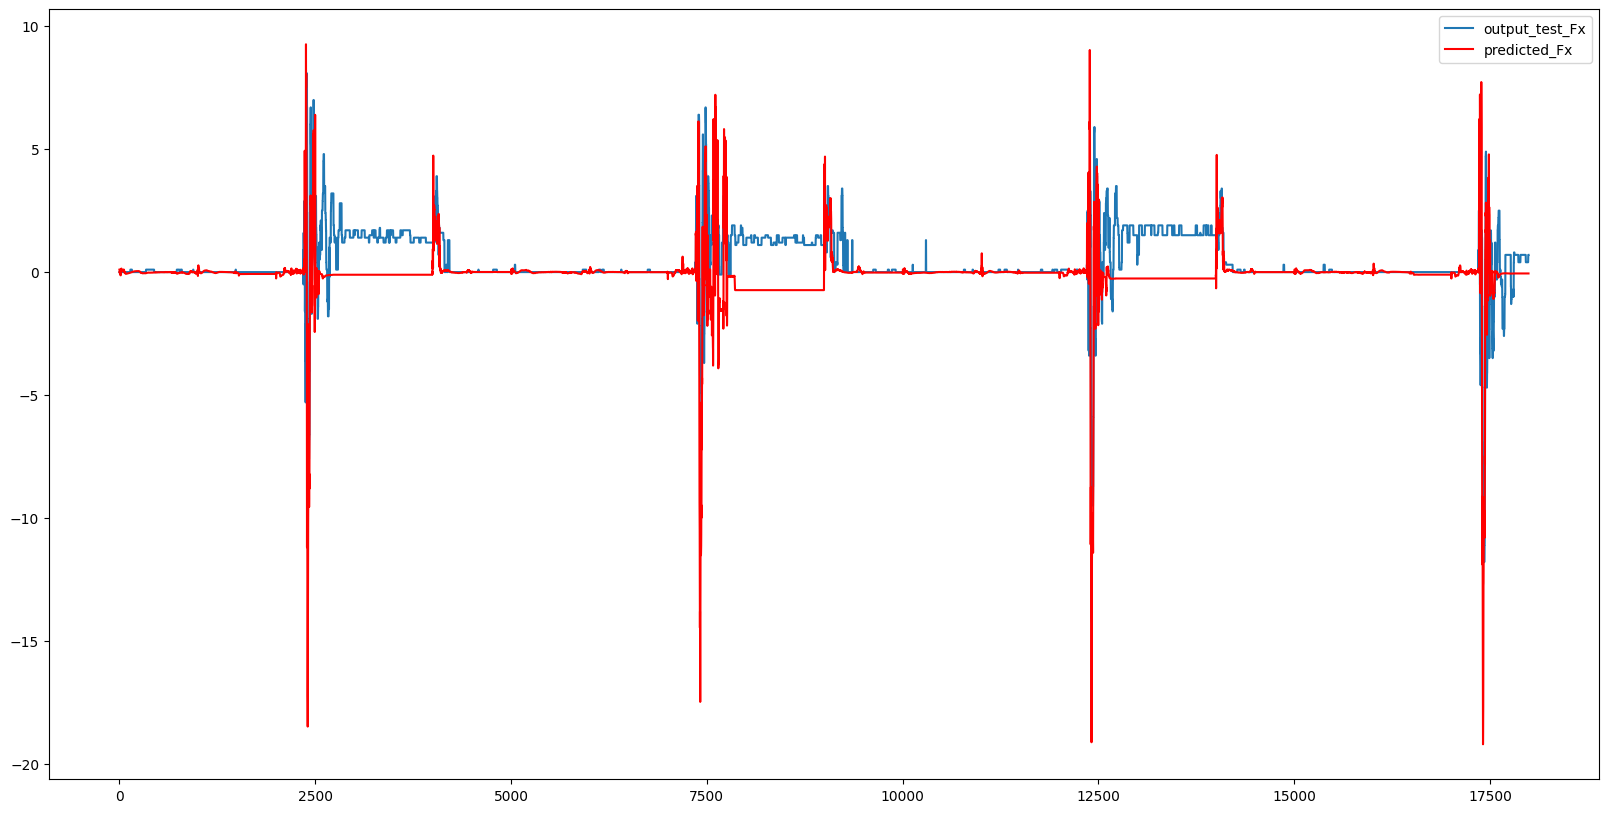

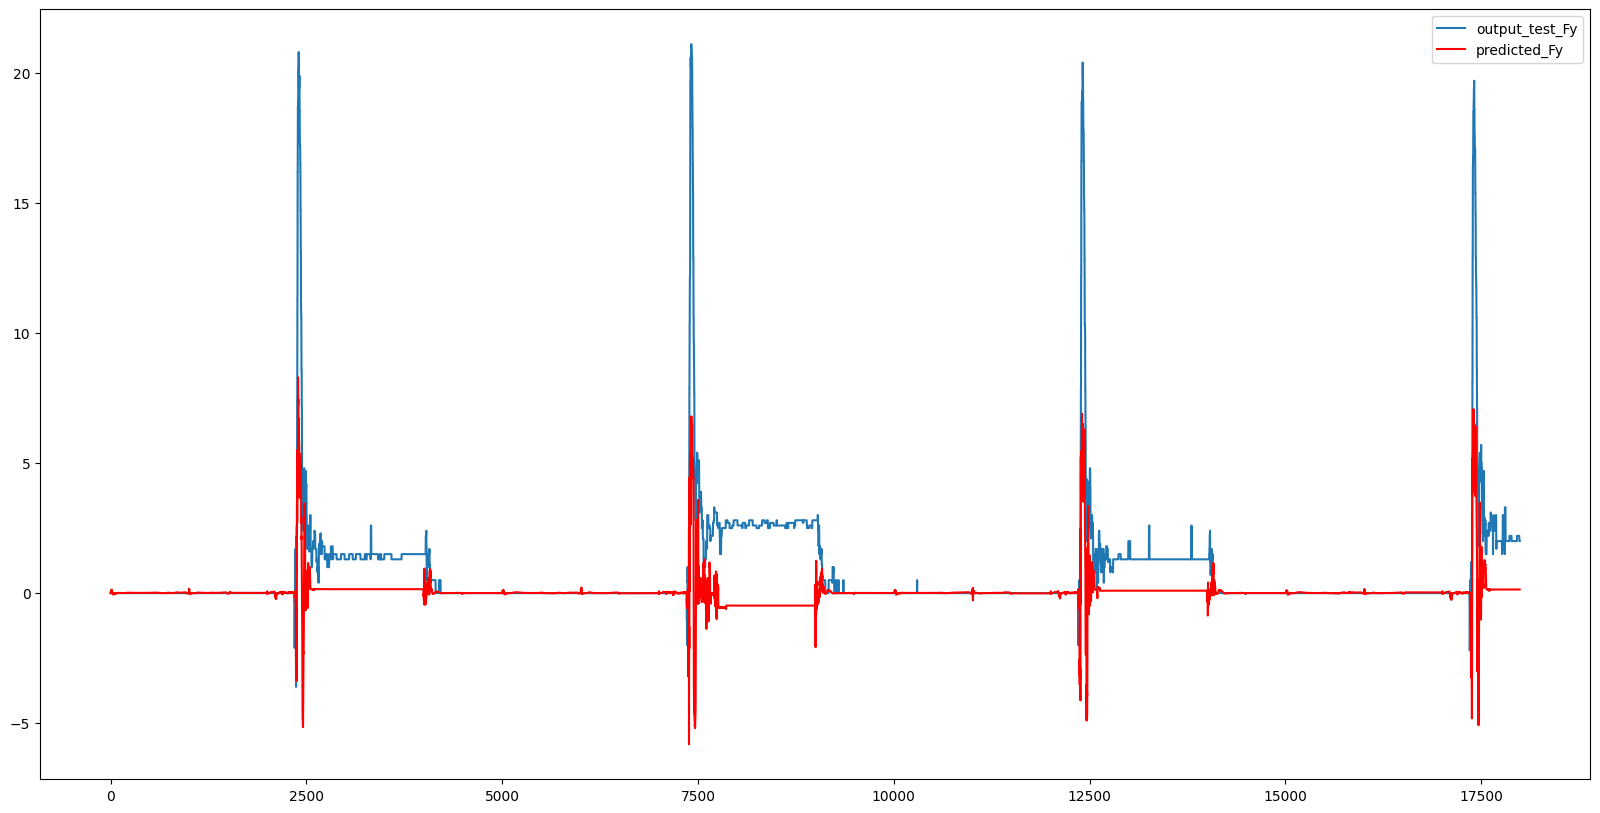

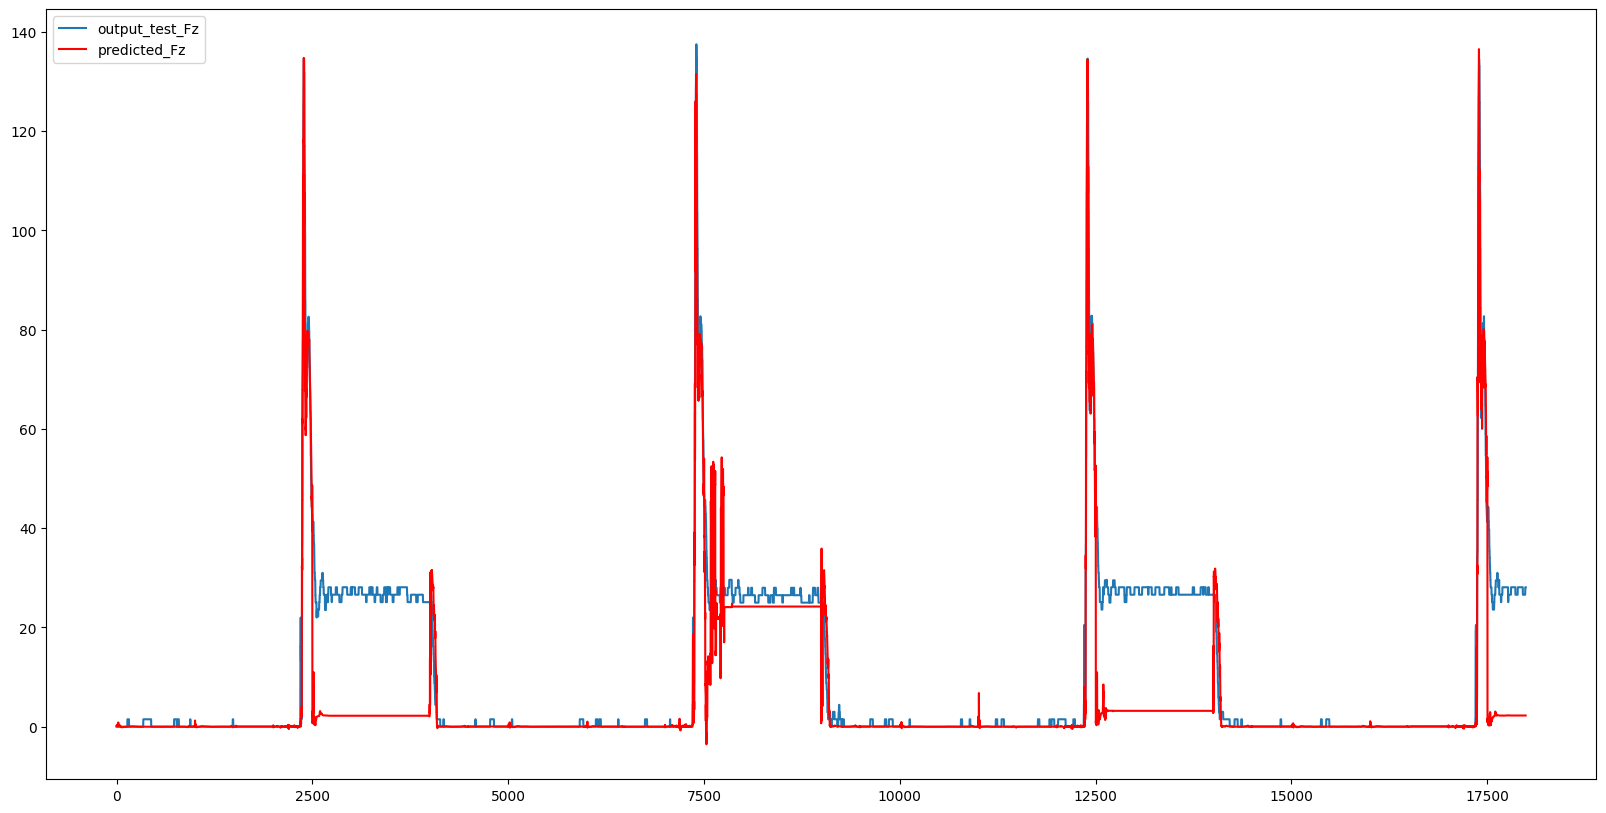

In [6]:
fig = plt.figure(figsize=(20, 10))
plt.plot(output_test_x , label="output_test_Fx")
plt.plot(predicted[:,0], 'r', label="predicted_Fx")
plt.legend()
plt.show()

fig = plt.figure(figsize=(20, 10))
plt.plot(output_test_y , label="output_test_Fy")
plt.plot(predicted[:,1], 'r', label="predicted_Fy")
plt.legend()
plt.show()

fig = plt.figure(figsize=(20, 10))
plt.plot(output_test_z, label="output_test_Fz")
plt.plot(predicted[:,2],'r', label="predicted_Fz")
plt.legend()
plt.show()